In [1]:
from collections import Counter, defaultdict
from music21 import converter, note, key, stream, meter, instrument
import matplotlib.pyplot as plt


📂 Loaded:
- Model: generated-music/multi/multi_RNN_18.mid
- Random: generated-music/random/multi_random_2.mid


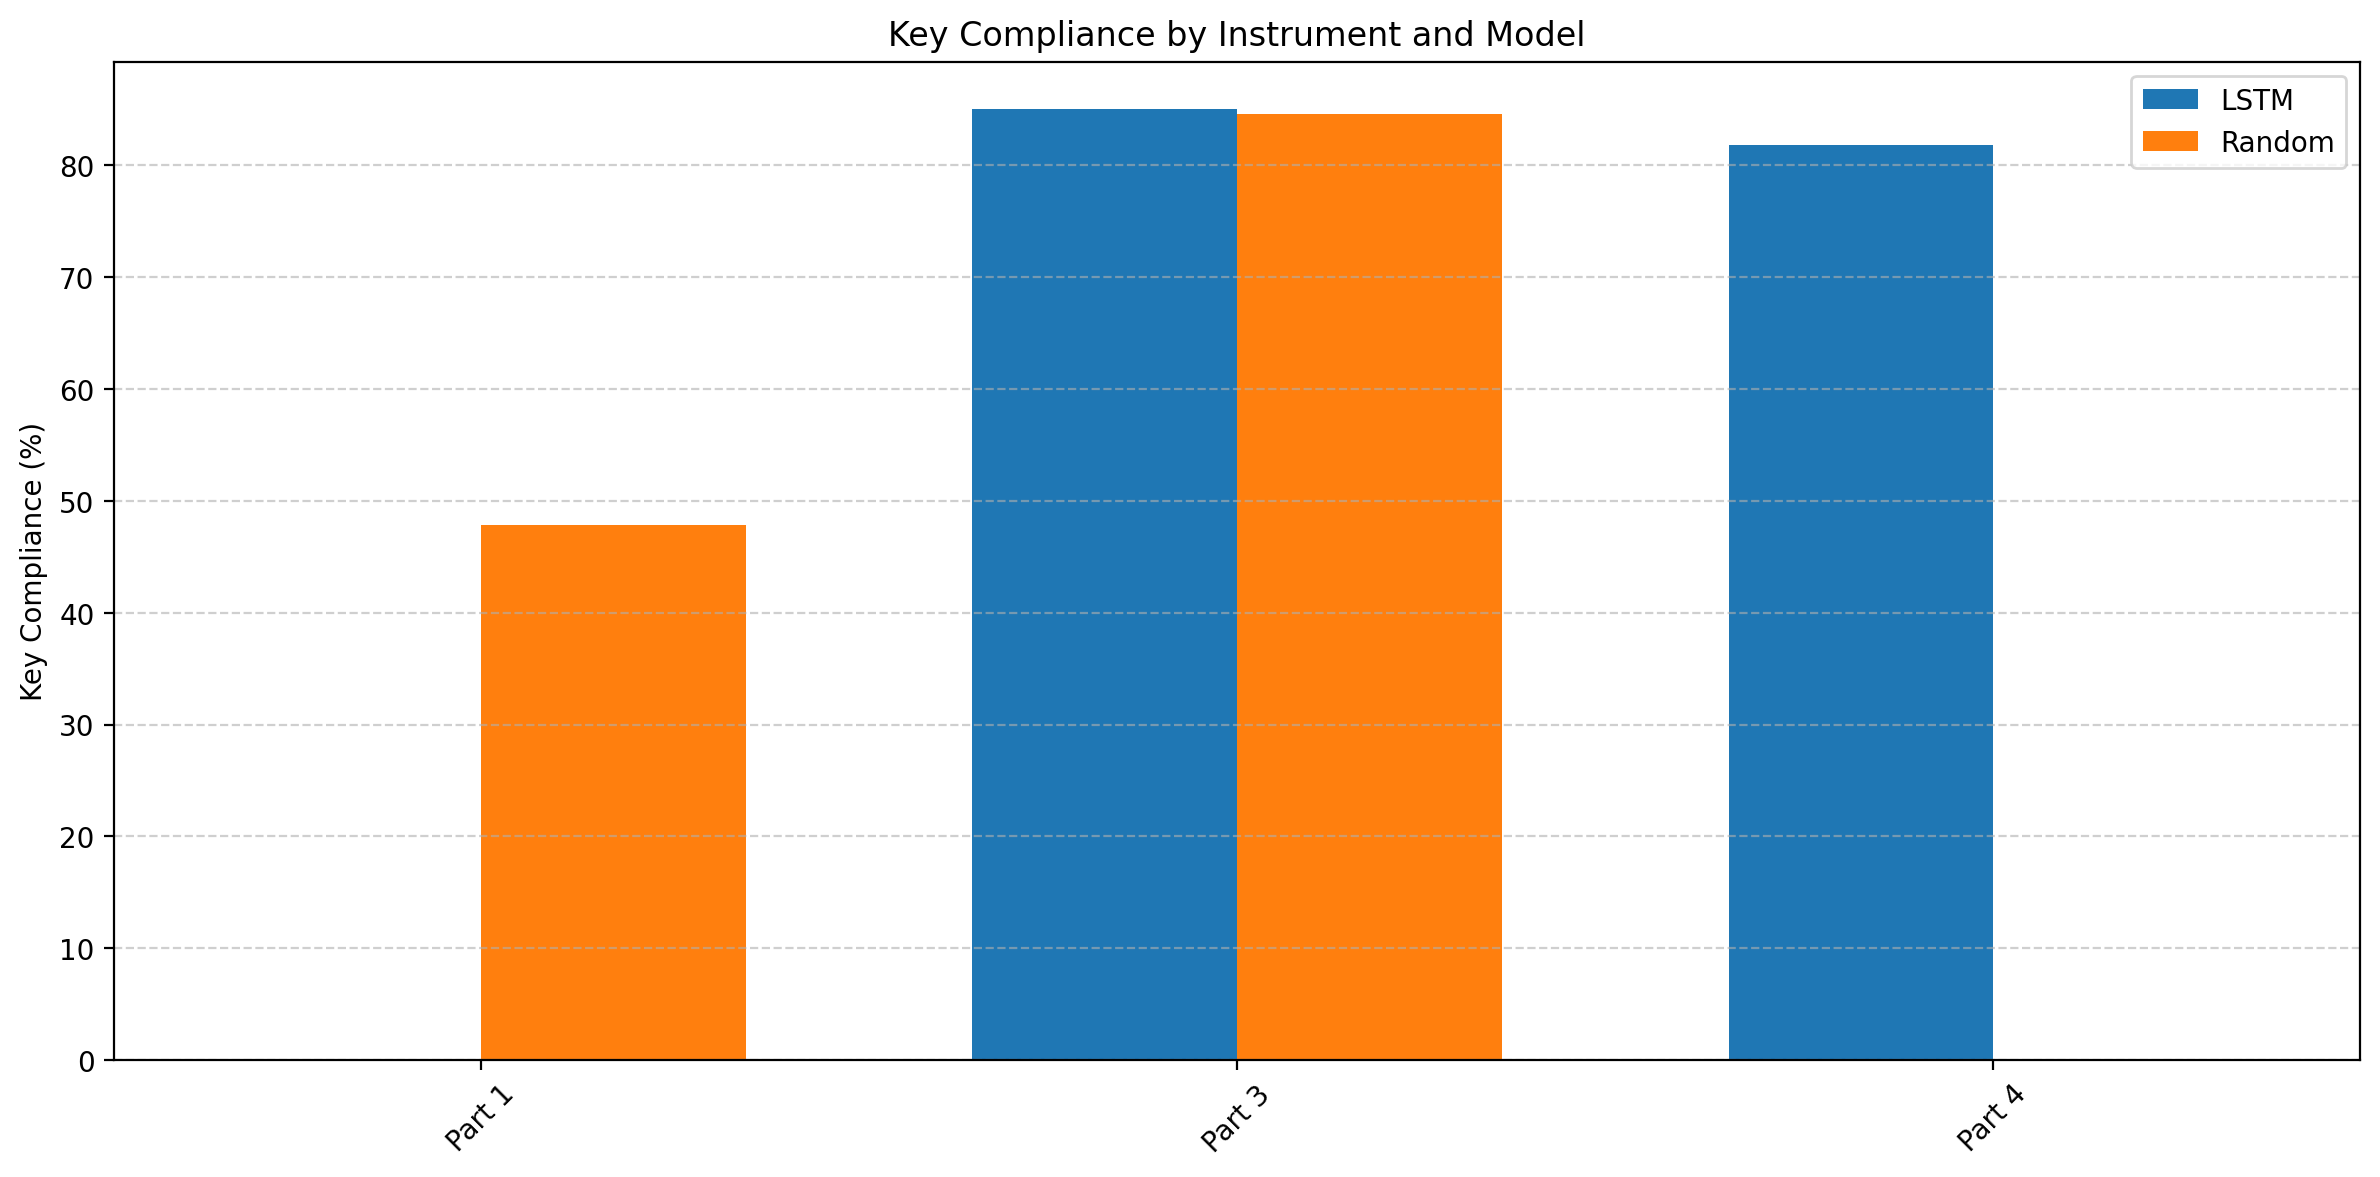

In [13]:
from music21 import converter, note, instrument
from collections import defaultdict
import matplotlib.pyplot as plt

# --- Analysis: Key Compliance per Instrument ---

def compute_key_compliance_per_instrument(midi_stream, label):
    results = []

    for i, part in enumerate(midi_stream.parts):
        instr = part.getInstrument(returnDefault=True)
        if isinstance(instr, instrument.Percussion) or 'drum' in str(instr).lower():
            continue

        try:
            detected_key = part.analyze('key')
        except Exception as e:
            print(f"⚠️ Could not detect key for {instr.instrumentName or f'Part {i+1}'}: {e}")
            continue

        allowed_notes = set(p.name for p in detected_key.pitches)
        total_notes = 0
        nonconforming_notes = 0

        for el in part.recurse():
            if isinstance(el, note.Note):
                total_notes += 1
                if el.pitch.name not in allowed_notes:
                    nonconforming_notes += 1

        if total_notes > 0:
            compliance = 100 * (1 - nonconforming_notes / total_notes)
            results.append({
                "instrument": instr.instrumentName or f"Part {i+1}",
                "compliance": compliance,
                "label": label
            })

    return results

# --- Visualization: Bar Chart by Instrument ---

def plot_key_compliance_by_instrument(results_list):
    instruments = sorted(set(r["instrument"] for r in results_list))
    models = sorted(set(r["label"] for r in results_list))

    data = {model: [] for model in models}
    for instr in instruments:
        for model in models:
            match = next((r for r in results_list if r["instrument"] == instr and r["label"] == model), None)
            data[model].append(match["compliance"] if match else 0)

    x = range(len(instruments))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, model in enumerate(models):
        ax.bar([p + i * width for p in x], data[model], width=width, label=model)

    ax.set_xticks([p + width * (len(models) / 2 - 0.5) for p in x])
    ax.set_xticklabels(instruments, rotation=45)
    ax.set_ylabel("Key Compliance (%)")
    ax.set_title("Key Compliance by Instrument and Model")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Driver Function ---

def compare_midi_key_compliance(model_file_path, random_file_path, model_label="LSTM", baseline_label="Random"):
    try:
        model_stream = converter.parse(model_file_path)
        random_stream = converter.parse(random_file_path)
    except Exception as e:
        print(f"❌ Error loading MIDI files: {e}")
        return

    print(f"\n📂 Loaded:\n- Model: {model_file_path}\n- Random: {random_file_path}")

    model_results = compute_key_compliance_per_instrument(model_stream, model_label)
    random_results = compute_key_compliance_per_instrument(random_stream, baseline_label)

    plot_key_compliance_by_instrument(model_results + random_results)

# --- Example Usage ---

model_file = "generated-music/multi/multi_RNN_18.mid"
random_file = "generated-music/random/multi_random_2.mid"
compare_midi_key_compliance(model_file, random_file)


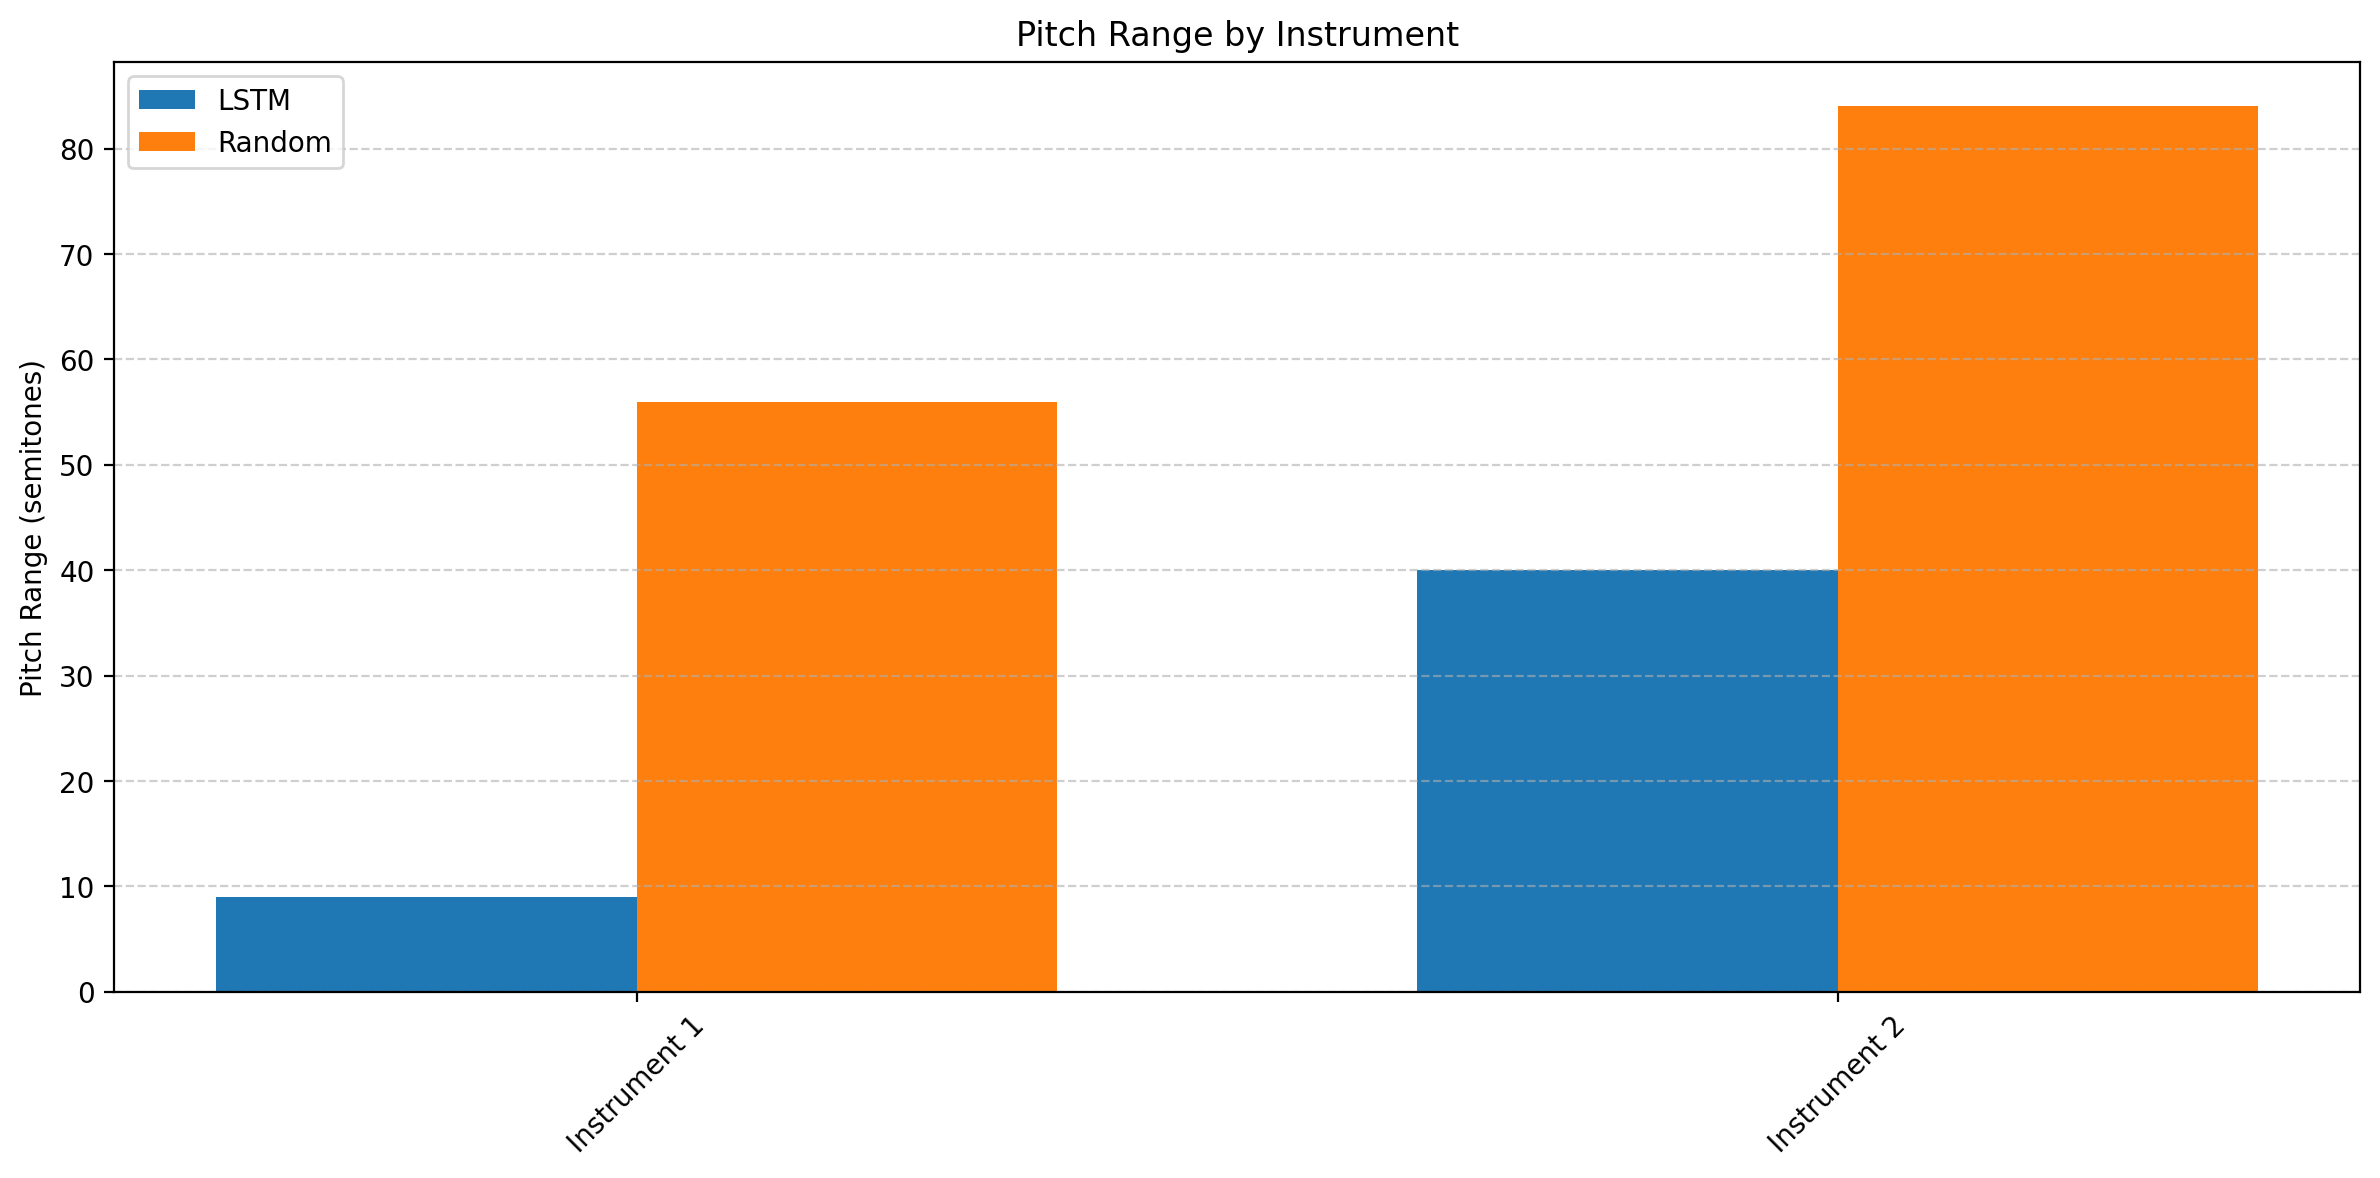

In [27]:
from music21 import converter, note, instrument
import matplotlib.pyplot as plt
import statistics

# --- Analysis Function ---

def compute_instrument_metrics(midi_stream, label):
    results = []

    for i, part in enumerate(midi_stream.parts):
        instr = part.getInstrument(returnDefault=True)
        name = instr.instrumentName or f"Instrument {int((i+1)/2 + 1/2)}"

        if isinstance(instr, instrument.Percussion) or 'drum' in name.lower():
            continue

        try:
            detected_key = part.analyze('key')
        except Exception:
            continue

        allowed_notes = set(p.name for p in detected_key.pitches)

        total_notes = 0
        nonconforming = 0
        velocities = []
        pitches = []

        for el in part.recurse():
            if isinstance(el, note.Note):
                total_notes += 1
                pitches.append(el.pitch.midi)
                velocities.append(el.volume.velocity or 64)
                if el.pitch.name not in allowed_notes:
                    nonconforming += 1

        if total_notes == 0:
            continue

        key_compliance = 100 * (1 - nonconforming / total_notes)
        avg_velocity = statistics.mean(velocities) if velocities else 64
        pitch_range = max(pitches) - min(pitches) if len(pitches) >= 2 else 0

        results.append({
            "instrument": name,
            "label": label,
            "key_compliance": key_compliance,
            "avg_velocity": avg_velocity,
            "pitch_range": pitch_range
        })

    return results

# --- Plotting Function ---

def plot_grouped_bar_chart(data, metric_name, title, ylabel):
    instruments = sorted(set(d["instrument"] for d in data))
    models = sorted(set(d["label"] for d in data))

    metric_data = {model: [] for model in models}
    for instr in instruments:
        for model in models:
            match = next((d for d in data if d["instrument"] == instr and d["label"] == model), None)
            value = match[metric_name] if match else 0
            metric_data[model].append(value)

    x = range(len(instruments))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, model in enumerate(models):
        ax.bar([p + i * width for p in x], metric_data[model], width=width, label=model)

    ax.set_xticks([p + width * (len(models) / 2 - 0.5) for p in x])
    ax.set_xticklabels(instruments, rotation=45)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Driver Function ---

def compare_midi_models(model_file_path, random_file_path, model_label="LSTM", baseline_label="Random"):
    try:
        model_stream = converter.parse(model_file_path)
        random_stream = converter.parse(random_file_path)
    except Exception as e:
        print(f"❌ Error loading MIDI files: {e}")
        return

    model_metrics = compute_instrument_metrics(model_stream, model_label)
    random_metrics = compute_instrument_metrics(random_stream, baseline_label)
    combined = model_metrics + random_metrics

    #plot_grouped_bar_chart(combined, "key_compliance", "Key Compliance by Instrument", "Key Compliance (%)")
    #plot_grouped_bar_chart(combined, "avg_velocity", "Average Velocity by Instrument", "Average Velocity")
    plot_grouped_bar_chart(combined, "pitch_range", "Pitch Range by Instrument", "Pitch Range (semitones)")

# --- Example Usage ---

model_file = "generated-music/multi/multi_RNN_25.mid"
random_file = "generated-music/random/multi_random_2.mid"
compare_midi_models(model_file, random_file)
